Ce notebook contient toutes les étapes qui nous permettent de traiter les données et d'entrainer notre IA.

Importations

In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

Definition de quelques fonctions utiles :

In [2]:
def load_images_from_folder(folder_path, target_size=None):
    images = []
    filenames = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            image = Image.open(img_path)
            if target_size:
                image = image.resize(target_size)  # Redimensionner l'image si nécessaire
            image_array = np.array(image)  # Convertir l'image en tableau NumPy
            images.append(image_array)
            filenames.append(filename)
    return np.array(images), filenames

def normalize(images):
    s=images.shape
    images = images.astype("float32")/255
    images = images.reshape(s[0],s[1]*s[2]*s[3])
    return images

def normalize_conv(images):
    images = images.astype("float32")/255
    return images

def denormalize(img):
    img = img.reshape(400,400,3)
    return img

def plotimage(img):
    img = denormalize(img)
    plt.imshow(img)
    plt.axis('off')  # Masquer les axes
    plt.show()



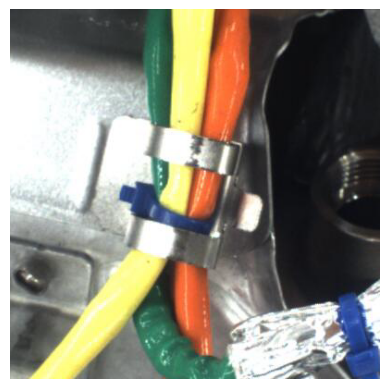

In [3]:
folder_path = '/home/jgayraud/Documents/MIC3/BE/engine_wiring/train/good'
target_size = (400, 400)  
images, filenames = load_images_from_folder(folder_path, target_size)

images_conv = normalize_conv(images)
images = normalize(images)
plotimage(images[3,:])


In [4]:

images_conv.shape


(285, 400, 400, 3)

Le code suivant est la classe permettant de créer cette IA avec  plusieurs fonctions

Definition du modèle :

In [5]:
class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        # Building an linear encoder with Linear
        # layer followed by Relu activation function
        # 784 ==> 9
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(400*400*3, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 20)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 100),
            torch.nn.ReLU(),
            torch.nn.Linear(100, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500,400*400*3),
            torch.nn.Sigmoid()
        )
 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [6]:
class AE_CNN(torch.nn.Module):
    def __init__(self):
        super(AE_CNN, self).__init__()
       
        # --- ENCODEUR CNN ---
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(3, 32, kernel_size=4, stride=2, padding=1),  # 400x400 → 200x200
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # 200x200 → 100x100
            torch.nn.ReLU(),
            torch.nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 100x100 → 50x50
            torch.nn.ReLU(),
            torch.nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 50x50 → 25x25
            torch.nn.ReLU(),
            torch.nn.Flatten(),
            torch.nn.Linear(256 * 25 * 25, 20)  # Vecteur latent de taille 20
        )
       
        # --- DÉCODEUR CNN ---
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(20, 256 * 25 * 25),  # Reconversion du vecteur latent
            torch.nn.ReLU(),
            torch.nn.Unflatten(1, (256, 25, 25)),  # Reformater en "image" 2D
           
            torch.nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # 25x25 → 50x50
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 50x50 → 100x100
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 100x100 → 200x200
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 3, kernel_size=4, stride=2, padding=1),  # 200x200 → 400x400
            torch.nn.Sigmoid()  # Normalisation entre 0 et 1
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [7]:
torch.cuda.is_available()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#torch.device("cpu") 
print(device)

cuda


Definition du loader ( la database qui va servir à s'entrainer en prenant en compte le bash (nombre d'itérations avant update)) et de certains hyperparamètres

In [8]:
#images_for_conv = images.reshape(images[0],400,400,3 )

In [9]:
# les to(device) deplace les objets sur le gpu pour faire le training
torch.cuda.empty_cache()
if 'model' in locals():
    del model
if 'optimizer' in locals():
    del optimizer
if 'images_tensor' in locals():
    del images_tensor
if 'dataset' in locals():
    del dataset
if 'loader' in locals():
    del loader


model = AE_CNN().to(device)
BashSize = 32


loss_function = torch.nn.BCELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-3,
                             weight_decay = 1e-5,
                             foreach=True)


images_tensor = torch.tensor(images, dtype=torch.float32).to(device)

images_tensor_conv = torch.tensor(images_conv, dtype=torch.float32).permute(0,3,1,2).to(device)



#dataset = TensorDataset(images_tensor)

loader = torch.utils.data.DataLoader(dataset = images_tensor_conv,
                                     batch_size = BashSize,
                                     shuffle = True)

In [13]:


import gc

Entrainement du modèle :

In [ ]:
num_epochs = 20
losses = []
optimizer.zero_grad()
for epoch in range(num_epochs):
    for batch in loader:
        # Séparer les données d'entrée et les cibles (ici, les mêmes images)
        inputs = batch.to(device)
        targets = inputs
        
        # Passer les données dans le modèle

        outputs = model(inputs)
        # Calculer la perte
        loss = loss_function(outputs, targets)

        # Rétropropagation et mise à jour des poids
        loss.backward()
        optimizer.step()    
        # Remettre les gradients à zéro
        optimizer.zero_grad()
        losses.append(loss.item())

        # supprimer ce qui ne nous sert plus pour libérer la mémoire (probleme de taille)
        del inputs, targets, outputs
        gc.collect()
        torch.cuda.empty_cache()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print("Entraînement terminé.")



Epoch [1/20], Loss: 0.5362
Epoch [2/20], Loss: 0.5367
Epoch [3/20], Loss: 0.5485
Epoch [4/20], Loss: 0.5406
Epoch [5/20], Loss: 0.5382
Epoch [6/20], Loss: 0.5437
Epoch [7/20], Loss: 0.5378
Epoch [8/20], Loss: 0.5406
Epoch [9/20], Loss: 0.5346
Epoch [10/20], Loss: 0.5364
Epoch [11/20], Loss: 0.5357


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 0 has a total capacity of 10.89 GiB of which 55.56 MiB is free. Including non-PyTorch memory, this process has 10.16 GiB memory in use. Of the allocated memory 7.70 GiB is allocated by PyTorch, and 2.29 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

Enregistrement des poids pour les utiliser plus tard sans relancer le training

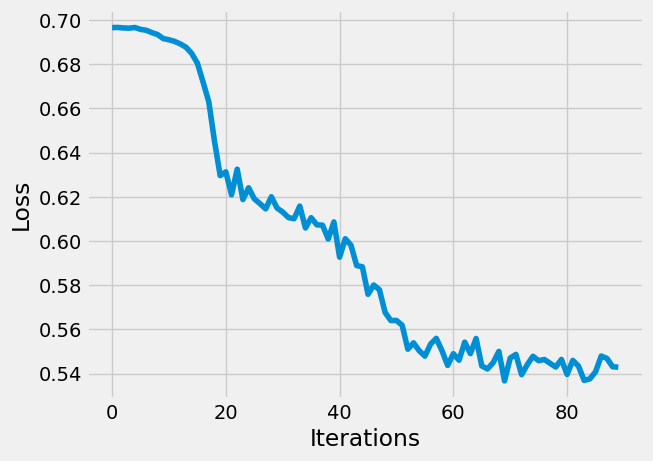

In [11]:
losses_np = [loss.cpu().detach().numpy() for loss in losses]

# Définir le style du graphique
plt.style.use('fivethirtyeight')
plt.xlabel('Iterations')
plt.ylabel('Loss')

# Tracer les 100 dernières valeurs de perte
plt.plot(losses_np[-100:])

# Afficher le graphique
plt.show()

Nous avons essayé dans un premier temps 10 époques mais nous remarquons une augmentation sygnificative du loss au bout de 5 époques. Nous devons modifier les hyperparamètres pour avoir un meilleur modèle.

Passage d'une image dans le modèle, pour vérifier la robustesse du modèle : Attention ceci est pour le modele linéaire

In [13]:
# Convertir l'image en tenseur
number = 3

image_tensor = torch.tensor(images[number, :], dtype=torch.float32).view(1, -1)

# Passer l'image à travers le modèle pour obtenir la reconstruction
model.eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = model(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images[number, :].reshape(400, 400, 3)
reconstructed_image = reconstructed_image.view(400, 400, 3).numpy()

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()

RuntimeError: Expected 3D (unbatched) or 4D (batched) input to conv2d, but got input of size: [1, 480000]

Attention ceci est l'affichage pour le modele de convolution

torch.Size([1, 3, 400, 400])
torch.Size([1, 3, 400, 400])
(400, 400, 3)


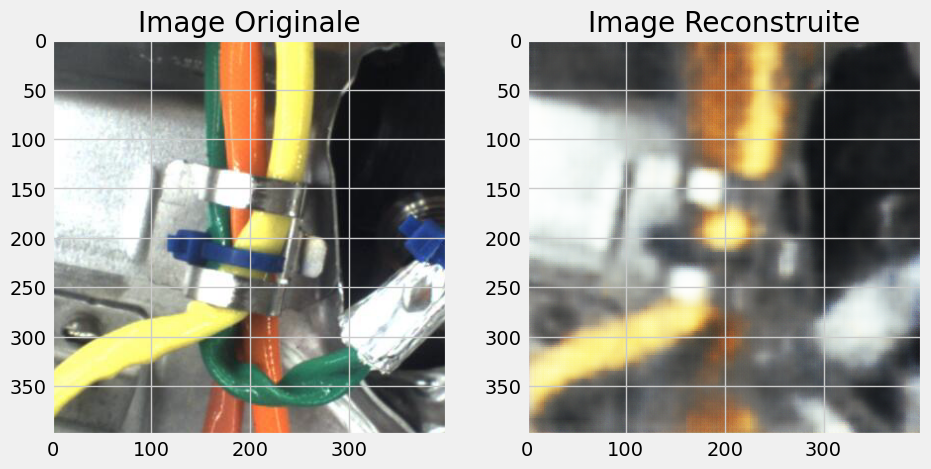

tensor([0.1961, 0.2078, 0.2196,  ..., 0.3961, 0.4980, 0.6745], device='cuda:0')
[[0.32187903 0.33469307 0.37024632]
 [0.28652483 0.28016138 0.30287954]
 [0.27221897 0.28843522 0.26989707]
 ...
 [0.43382174 0.4341154  0.42685267]
 [0.44067886 0.43081835 0.4133994 ]
 [0.4645773  0.43703085 0.45195445]]


: 

In [ ]:
# Convertir l'image en tenseur
number = 100

image_tensor = torch.tensor(images_conv[number, :,:,:], dtype=torch.float32).cuda().permute(2,0,1).reshape(1,3,400,400)
print(image_tensor.shape)
# Passer l'image à travers le modèle pour obtenir la reconstruction
model.eval()  # Passer le modèle en mode évaluation
with torch.no_grad():
    reconstructed_image = model(image_tensor)

# Remettre en forme et afficher l'image originale et la reconstruction
original_image = images_conv[number, :,:,:]
print(reconstructed_image.shape)
reconstructed_image = reconstructed_image.cpu().squeeze(0).permute(1,2,0).numpy()

print(reconstructed_image.shape)
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title('Image Originale')
plt.imshow(original_image)

plt.subplot(1, 2, 2)
plt.title('Image Reconstruite')
plt.imshow(reconstructed_image)

plt.show()

print(images_tensor[3])
print(reconstructed_image[3])

Pour l'instant, nous avons une image de sortie similaire peu importe l'image de départ. On suppose que le modèle est mal entrainé (Trop d'époques ou autres), ou une erreur dans lecode